In [1]:
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import numpy as np

from scipy.spatial.distance import cdist
from torch.nn import functional as F
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import flow_ssl
from flow_ssl.realnvp import RealNVP
from flow_ssl import FlowLoss
from flow_ssl.data import make_sup_data_loaders
from tqdm import tqdm
from torch import distributions
import torch.nn as nn
import math
import cmocean.cm as cmo

from flow_ssl.invertible import SqueezeLayer
from flow_ssl.invertible import iSequential, both, Id
from flow_ssl.realnvp.coupling_layer import CouplingLayer
from flow_ssl.invertible.downsample import iLogits
from flow_ssl.realnvp.coupling_layer import MaskCheckerboard, MaskChannelwise
import logging

%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


### Loading model

In [1]:
img_shape = (3, 32, 32)
transform_train = transforms.Compose([
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

data_path = "datasets/"

_, cifar_testloader, _ = make_sup_data_loaders(
        data_path, 
        32, 
        4, 
        transform_train, 
        transform_test, 
        use_validation=False,
        shuffle_train=False,
        dataset="cifar10")

_, svhn_testloader, _ = make_sup_data_loaders(
        data_path, 
        32, 
        4, 
        transform_train, 
        transform_test, 
        use_validation=False,
        shuffle_train=False,
        dataset="svhn")

trainloader, testloader, _ = make_sup_data_loaders(
        data_path, 
        32, 
        4, 
        None, 
        None, 
        use_validation=False,
        shuffle_train=False,
        dataset="celeba")

In [4]:
model_cfg = flow_ssl.RealNVP
net = model_cfg(in_channels=img_shape[0], init_zeros=False, num_blocks=8, num_scales=3)
print("Model contains {} parameters".format(sum([p.numel() for p in net.parameters()])))
net = torch.nn.DataParallel(net, [0])

Model contains 87859080 parameters


This checkpoint is on desktop

In [5]:
net.load_state_dict(torch.load(
    "flow_ood/experiments/train_flows/ckpts/" 
    "realnvp_celeba100.pt")["net"])
net.cuda();

In [6]:
# first forward pass before reverse
net.eval();
for x, _ in trainloader:
    net(x)
    break

In [7]:
class FlowLossList(nn.Module):
    def __init__(self, prior, k=256):
        super().__init__()
        self.k = k
        self.prior = prior

    def forward(self, z, sldj):
        z = z.reshape((z.shape[0], -1))
        prior_ll = self.prior.log_prob(z)
        corrected_prior_ll = prior_ll - np.log(self.k) * np.prod(z.size()[1:])
        ll = corrected_prior_ll + sldj
        return ll

In [8]:
def get_loss_vals(loss_fn, loader, net, testmode=True):
    if testmode:
        net.eval()
    else:
        net.train()
    loss_vals = []

    with torch.no_grad():
        with tqdm(total=len(loader.dataset)) as progress_bar:
            for x, _ in loader:
                x = x.cuda()
                z = net(x)
                sldj = net.module.logdet()
                
                losses = loss_fn(z, sldj=sldj)
                loss_vals.extend([loss.item() for loss in losses])

                progress_bar.update(x.size(0))
    return np.array(loss_vals)

In [9]:
def get_reshape_model(in_channels, num_blocks, trainloader, num_scales):
    reshape_model_ilogits = model_cfg(in_channels=in_channels, num_blocks=num_blocks, num_scales=num_scales)
    reshape_model_wo_ilogits = model_cfg(in_channels=in_channels, num_blocks=num_blocks, num_scales=num_scales)
    reshape_model_ilogits.cpu(); reshape_model_wo_ilogits.cpu();
    reshape_model_ilogits.eval(); reshape_model_wo_ilogits.eval();

    for m in reshape_model_ilogits.body._modules.values():
        if isinstance(m, iSequential):
            for subm in m._modules.values():
                if isinstance(subm, both):
                    if isinstance(subm.module1, CouplingLayer):
                        subm.module1 = Id()
                    if isinstance(subm.module2, CouplingLayer):
                        subm.module2 = Id()

    for m in reshape_model_wo_ilogits.body._modules.values():
        if isinstance(m, iSequential):
            for subm in m._modules.values():
                if isinstance(subm, both):
                    if isinstance(subm.module1, CouplingLayer) or isinstance(subm.module1, iLogits):
                        subm.module1 = Id()
                    if isinstance(subm.module2, CouplingLayer) or isinstance(subm.module1, iLogits):
                        subm.module2 = Id()
    
    # first foward pass before reverse
    for x, _ in trainloader:
        reshape_model_ilogits(x)
        reshape_model_wo_ilogits(x)
        break

    return reshape_model_ilogits, reshape_model_wo_ilogits

In [10]:
def draw_st_output(st_activation, x, idx=0):
    z = net(x)
    
    numcols = len(st_activation)
    f, axes = plt.subplots(2, numcols, figsize=(16, 2), sharex=True, sharey=True)
    s_list = []
    t_list = []

    for k, (name, act) in enumerate(st_activation.items()):
        st = st_activation[name]
        i, j = [int(a) for a in name[6:].split('.')]
        s, t = st.chunk(2, dim=1)
        s = net.module.body[i][j].module1.rescale(torch.tanh(s))
        s, t = net.module.body[i][j].module1.mask.mask_st_output(s, t)
        s = s.exp()
        
        if isinstance(net.module.body[i][j].module1.mask, MaskChannelwise):
            if net.module.body[i][j].module1.mask.reverse_mask:
                s = torch.cat((torch.ones_like(s), s), 1)
                t = torch.cat((torch.zeros_like(t), t), 1)
            else:
                s = torch.cat((s, torch.ones_like(s)), 1)
                t = torch.cat((t, torch.zeros_like(t)), 1)

        # after 2nd keepChannels
        if i > 9:
            s = torch.cat((s, torch.ones_like(s)), 1)
            t = torch.cat((t, torch.zeros_like(t)), 1)
        
        # after 2nd Squeeze
        if i > 7:
            sq_layer = SqueezeLayer(downscale_factor=2)
            s, t = sq_layer.inverse(s), sq_layer.inverse(t)
        
        # after 1st keepChannels
        if i > 5:
            s = torch.cat((s, torch.ones_like(s)), 1)
            t = torch.cat((t, torch.zeros_like(t)), 1)
        
        # after 1st Squeeze
        if i > 3:
            sq_layer = SqueezeLayer(downscale_factor=2)
            s, t = sq_layer.inverse(s), sq_layer.inverse(t)
        
        s_ = s.permute(0, 2, 3, 1).cpu().detach().numpy()
        t_ = t.permute(0, 2, 3, 1).cpu().detach().numpy()
        s_list.append(s_[:, None, :])
        t_list.append(t_[:, None, :])
        s_ = s_[idx]
        t_ = t_[idx]

        f1 = axes[0][k].imshow((s_ - s_.mean()) / s_.std())
        f2 = axes[1][k].imshow((t_ - t_.mean()) / t_.std())
#         f1 = axes[0][k].imshow(s_)
#         f2 = axes[1][k].imshow(t_)

        axes[0][k].set_xticks([]) 
        axes[0][k].set_yticks([]) 
        axes[1][k].set_xticks([]) 
        axes[1][k].set_yticks([]) 
#         axes[0][k].set_title('{}.{}'.format(i, j)) 

    axes[0][0].set_ylabel(r'$s$', rotation=0, fontsize=20, labelpad=17, va='center')
    axes[1][0].set_ylabel(r'$t$', rotation=0, fontsize=20, labelpad=17, va='center')

    plt.tight_layout()
    return np.concatenate(s_list, axis=1), np.concatenate(t_list, axis=1)

In [11]:
def draw_coupling_layer(cp_activation, x, idx=0):
    z = net(x)
    numcols = len(cp_activation)
    f, axes = plt.subplots(1, numcols, figsize=(16, 3), sharex=True, sharey=True)
    
    cp_list = []
    
    for k, (name, act) in enumerate(cp_activation.items()):
        cp = cp_activation[name]
        i, j = [int(a) for a in name[2:].split('.')]
            
        # after 2nd keepChannels
        if i > 9:
            cp_res = torch.cat((cp[0], cp[-1]), 1)
        else:
            cp_res = cp[0]
        
        # after 2nd Squeeze
        if i > 7:
            sq_layer = SqueezeLayer(downscale_factor=2)
            cp_res = sq_layer.inverse(cp_res)
        
        # after 1st keepChannels
        if i > 5:
            cp_res = torch.cat((cp_res, cp[1]), 1)
        
        # after 1st Squeeze
        if i > 3:
            sq_layer = SqueezeLayer(downscale_factor=2)
            cp_res = sq_layer.inverse(cp_res)

        cp_res = cp_res.permute(0, 2, 3, 1).cpu().detach().numpy()
        cp_list.append(cp_res[:, None, :])
        cp_res = cp_res[idx]

#         f1 = axes[k].imshow(cp_res)
        f1 = axes[k].imshow((cp_res - cp_res.mean()) / cp_res.std())

        axes[k].set_xticks([]) 
        axes[k].set_yticks([]) 
#         axes[k].set_title('{}.{}'.format(i, j))
        
    plt.tight_layout()
    return np.concatenate(cp_list, axis=1)

In [12]:
D = 3 * 32 * 32
prior = distributions.MultivariateNormal(torch.zeros(D).cuda(),
                                         torch.eye(D).cuda())
flowlosslist_fn = FlowLossList(prior)

**<center><font size="6">Evaluation Mode</center>**

# Samples

In [14]:
def sample(net, prior, batch_size):
    with torch.no_grad():
        z = prior.sample((batch_size,))
        x = net.module.inverse(z)
        return x

In [15]:
x_sampled = sample(net, prior, 9)
x_sampled_np = x_sampled.cpu().detach().numpy()

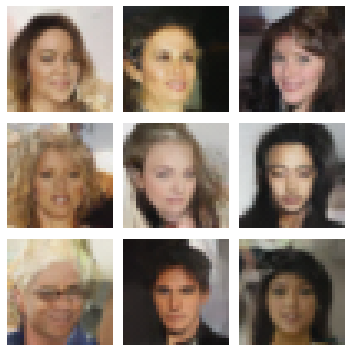

In [20]:
f, axes = plt.subplots(3, 3, figsize=(5, 5))
for i in range(9):
    axes[i//3][i%3].imshow(np.transpose(x_sampled_np[i], axes=[1, 2, 0]), cmap=cmo.ice)
    axes[i//3][i%3].axis('off')

plt.tight_layout()
# plt.savefig("img_src/realnvp_celeba/samples.pdf", bbox_inches="tight")

In [21]:
# np.savez('img_src/realnvp_celeba/samples.npz', samples=x_sampled_np)

## Likelihoods in Eval Mode

In [14]:
sns.set_style('whitegrid')

In [15]:
net.eval();

In [16]:
train_loss_vals = get_loss_vals(flowlosslist_fn, trainloader, net)
train_bpd = -train_loss_vals.mean() / (np.log(2) * 3*32*32)
print(train_bpd)

100%|██████████| 162770/162770 [16:21<00:00, 165.88it/s]

5.142965738928343


In [17]:
test_loss_vals = get_loss_vals(flowlosslist_fn, testloader, net)
test_bpd = -test_loss_vals.mean() / (np.log(2) * 3*32*32)
print(test_bpd)

100%|██████████| 19962/19962 [01:59<00:00, 166.55it/s]


5.267629046772157


In [18]:
ood_loss_vals = get_loss_vals(flowlosslist_fn, svhn_testloader, net)
ood_bpd = -ood_loss_vals.mean() / (np.log(2) * 3*32*32)
print(ood_bpd)

100%|██████████| 26032/26032 [02:36<00:00, 257.27it/s]

2.6750783173126793


In [19]:
cifar_loss_vals = get_loss_vals(flowlosslist_fn, cifar_testloader, net)
cifar_bpd = -cifar_loss_vals.mean() / (np.log(2) * 3*32*32)
print(cifar_bpd)

100%|██████████| 10000/10000 [00:59<00:00, 166.71it/s]


6.077623049488227


In [22]:
# np.savez('img_src/realnvp_celeba/likelihoods.npz',
#          celeba_train=train_loss_vals, celeba_test=test_loss_vals,
#          svhn=ood_loss_vals, cifar=cifar_loss_vals)

307 outliers
50 outliers
0 outliers
105 outliers


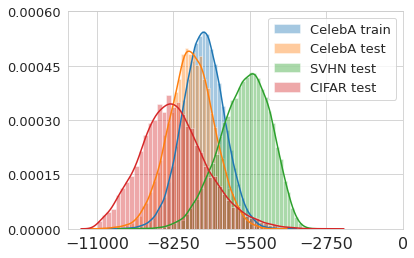

In [21]:
def filter_threshold(llarray, threshold):
    print(np.sum(llarray < threshold), "outliers")
    return llarray[llarray > threshold]

sns.distplot(filter_threshold(train_loss_vals, -11000), label="CelebA train")
sns.distplot(filter_threshold(test_loss_vals, -11000), label="CelebA test")
sns.distplot(filter_threshold(ood_loss_vals, -11000), label="SVHN test")
sns.distplot(filter_threshold(cifar_loss_vals, -11000), label="CIFAR test")
# plt.xlim(-5000, 5000)
plt.xticks(np.linspace(-11000, 0, 5), fontsize=16)
plt.yticks(np.linspace(0., 0.0006, 5), fontsize=13)
plt.legend(fontsize=13)
# plt.savefig("img_src/realnvp_celeba/likelihoods_hist.pdf", bbox_inches="tight")

<h1><span style="color:red">Jacobian and Latent distribution likelihoods</span></h1>

<h1><span style="color:red">BatchNorm statistics</span></h1>

<h1><span style="color:black">st-network outputs & per-coupling-layer-visualizations</span></h1>

Model structure

In [10]:
# for i, m in enumerate(net.module.body._modules.values()):
#     print(i, type(m))
#     if isinstance(m, iSequential):
#         for subm in m._modules.values():
#             print('\t', type(subm))
#             if isinstance(subm, both):
#                 print('\t\t', type(subm.module1))
#                 print('\t\t', type(subm.module2))

Coupling Layers

In [46]:
# for i, m in enumerate(net.module.body._modules.values()):
#     if isinstance(m, iSequential):
#         for subm in m._modules.values():
#             if isinstance(subm, both):
#                 if isinstance(subm.module1, CouplingLayer):
#                     print(i, type(subm.module1.st_net))
#                 if isinstance(subm.module2, CouplingLayer):
#                     print(i, type(subm.module2.st_net))

In [13]:
# Register forward hooks to save intermediate output

st_activation = {}
def get_st_activation(name):
    def hook(model, input, output):
        st_activation[name] = output.detach()
    return hook


cp_activation = {}
def get_cp_activation(name):
    def hook(model, input, output):
        res = [output[0].detach()]
        for k in range(len(output[1])):
            res.append(output[1][k].detach())
        cp_activation[name] = res
    return hook


for i in range(len(net.module.body)):
    if not isinstance(net.module.body[i], iSequential): continue

    for j in range(len(net.module.body[i])):
        if not isinstance(net.module.body[i][j], both): continue
        
        if isinstance(net.module.body[i][j].module1, CouplingLayer) or\
                 isinstance(net.module.body[i][j].module2, CouplingLayer):
            net.module.body[i][j].register_forward_hook(get_cp_activation('cp{}.{}'.format(i, j)))

        if isinstance(net.module.body[i][j].module1, CouplingLayer):
            net.module.body[i][j].module1.st_net.register_forward_hook(
                get_st_activation('st_net{}.{}'.format(i, j)))

        if isinstance(net.module.body[i][j].module2, CouplingLayer):
            net.module.body[i][j].module2.st_net.register_forward_hook(
                get_st_activation('st_net{}.{}'.format(i, j)))

In [14]:
for x, _ in testloader:
    break

In [15]:
z = net(x)

In [16]:
# for name, act in st_activation.items():
#     print(name, act.shape)

In [17]:
# for name, act in cp_activation.items():
#     print(name, *[a.shape for a in act])

### In-distribution

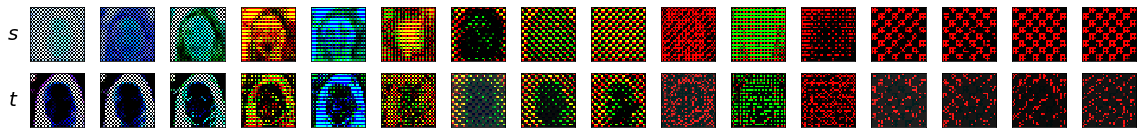

In [18]:
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

slist, tlist = draw_st_output(st_activation, x, idx=3)
# plt.savefig("img_src/realnvp_celeba/celeba_st.pdf", bbox_inches="tight")

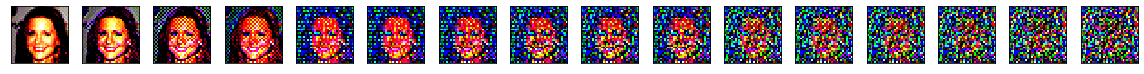

In [19]:
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

cplist = draw_coupling_layer(cp_activation, x, idx=3)
# plt.savefig("img_src/realnvp_celeba/celeba_coupling.pdf", bbox_inches="tight")

In [98]:
# np.savez('img_src/realnvp_celeba/celeba_st_coupling.npz',
#          x=x[3].cpu().numpy(), s=slist, t=tlist, coupling=cplist)

### Out-of-distribution

In [99]:
for x, _ in svhn_testloader:
    break

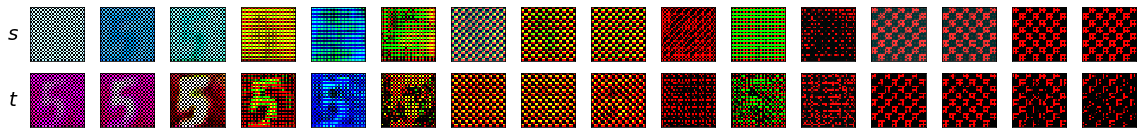

In [100]:
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

slist, tlist = draw_st_output(st_activation, x, idx=0)
# plt.savefig("img_src/realnvp_celeba/svhn_st.pdf", bbox_inches="tight")

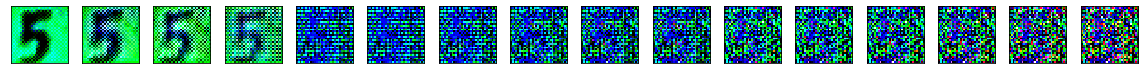

In [101]:
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

cplist = draw_coupling_layer(cp_activation, x, idx=0)
# plt.savefig("img_src/realnvp_celeba/svhn_coupling.pdf", bbox_inches="tight")

In [104]:
# np.savez('img_src/realnvp_celeba/svhn_st_coupling.npz',
#          x=x[0].cpu().numpy(), s=slist, t=tlist, coupling=cplist)

# Latent space visualizations

In [16]:
reshape_model_ilogits, reshape_model_wo_ilogits = get_reshape_model(
    in_channels=3, num_blocks=8, trainloader=trainloader, num_scales=3)

In [17]:
net.eval();
# net.train();

flowlosslist_fn = FlowLossList(prior)

In [18]:
# Index 21 for both in and OOD

[-6128.4599609375, -8716.970703125, -6671.53125, -7132.66796875, -7900.033203125, -8274.310546875, -7525.7958984375, -8582.1923828125, -9756.6162109375]


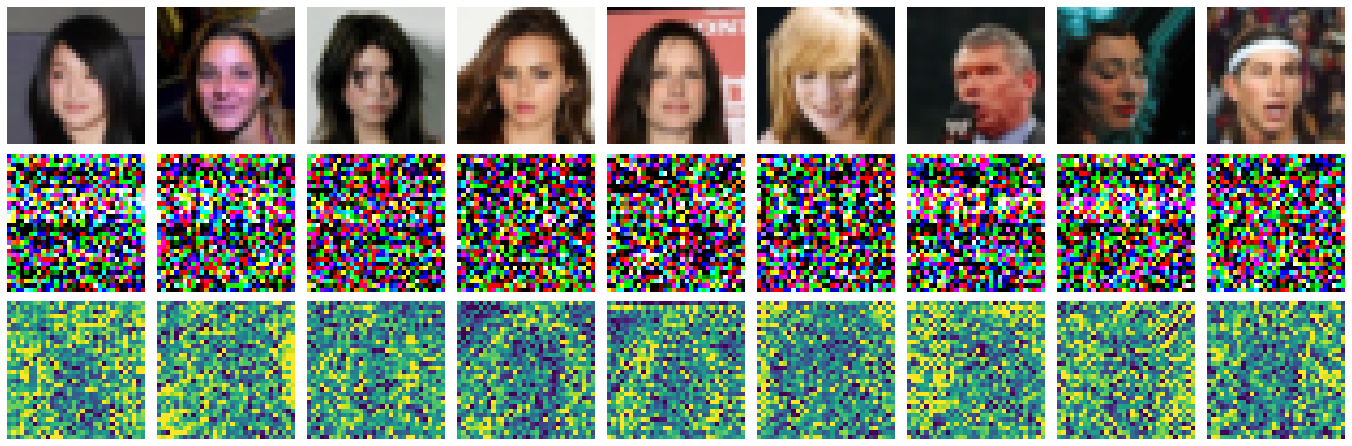

In [19]:
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

for x, y in testloader:
    break

with torch.no_grad():
    z = net(x)
    sldj = net.module.logdet()
    lls = flowlosslist_fn(z, sldj)

x_reconstr = reshape_model_wo_ilogits.inverse(z)
img_idx = [8, 12, 13, 21, 29, 30, 31, 1, 14]

nrows, ncols = 3, len(img_idx)
fig, arr = plt.subplots(nrows, ncols, figsize=(ncols*2.1, nrows*2.1))
    
for i, idx in enumerate(img_idx):
    x_ = x[idx].permute(1, 2, 0).detach().cpu().numpy()
    xrec_ = x_reconstr[idx].permute(1, 2, 0).detach().cpu().numpy()
    arr[0, i].imshow(x_, cmap=cmo.ice)
    arr[1, i].imshow(np.clip(z[idx].detach().cpu().numpy().reshape(32, 32, 3), -2, 2))
    arr[2, i].imshow(np.clip(xrec_[:, :, 2], -2, 2))
    arr[0, i].axis('off')
    arr[1, i].axis('off')
    arr[2, i].axis('off')

print([lls[idx].item() for idx in img_idx])
plt.tight_layout()

[-5059.4765625, -5048.41796875, -4204.08984375, -5894.6083984375, -4917.869140625, -4911.041015625, -4493.771484375, -5308.71484375, -4796.607421875]


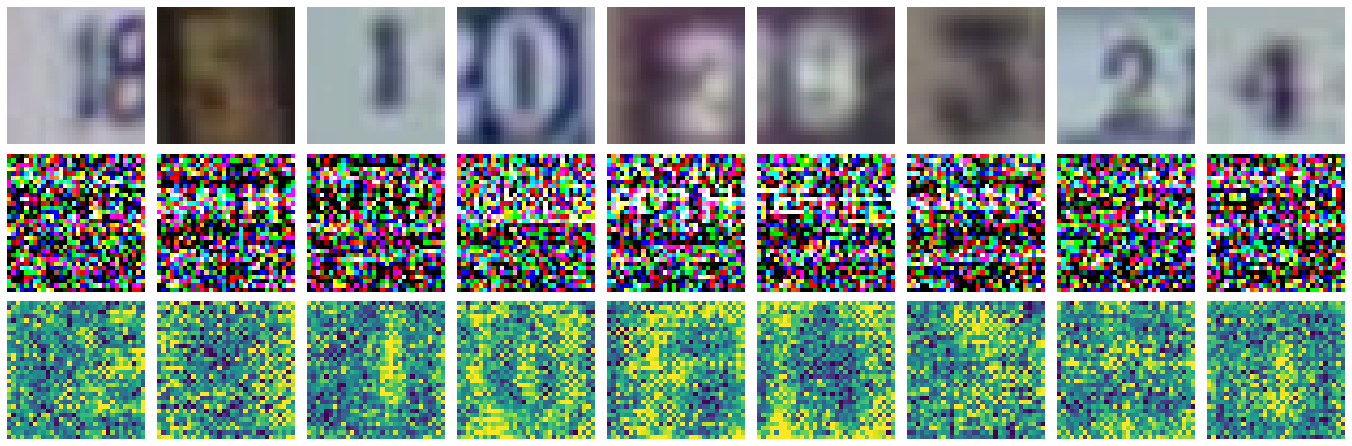

In [20]:
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

for x, y in svhn_testloader:
    break

with torch.no_grad():
    z = net(x)
    sldj = net.module.logdet()
    lls = flowlosslist_fn(z, sldj)

x_reconstr = reshape_model_wo_ilogits.inverse(z)
img_idx = [8, 12, 13, 21, 29, 30, 31, 1, 14]

nrows, ncols = 3, len(img_idx)
fig, arr = plt.subplots(nrows, ncols, figsize=(ncols*2.1, nrows*2.1))
    
for i, idx in enumerate(img_idx):
    x_ = x[idx].permute(1, 2, 0).detach().cpu().numpy()
    xrec_ = x_reconstr[idx].permute(1, 2, 0).detach().cpu().numpy()
    arr[0, i].imshow(x_, cmap=cmo.ice)
    arr[1, i].imshow(np.clip(z[idx].detach().cpu().numpy().reshape(32, 32, 3), -2, 2))
    arr[2, i].imshow(np.clip(xrec_[:, :, 2], -2, 2))
    arr[0, i].axis('off')
    arr[1, i].axis('off')
    arr[2, i].axis('off')

print([lls[idx].item() for idx in img_idx])
plt.tight_layout()

## Averaged representation and BatchNorm train-eval

### Eval mode

In [21]:
face_idx = 21

In [22]:
for x, _ in testloader:
    break

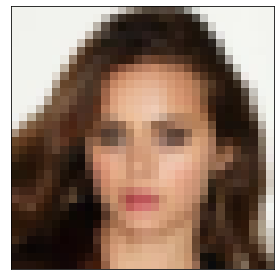

In [27]:
plt.figure(figsize=(4, 4))
face = x[face_idx].cpu().permute(1, 2, 0).numpy()
plt.imshow(face)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
# plt.savefig("img_src/realnvp_celeba/face.pdf", bbox_inches='tight')

In [28]:
z = net(x)

In [29]:
reshape_model_ilogits, reshape_model_wo_ilogits = get_reshape_model(
    in_channels=3, num_blocks=8, trainloader=trainloader, num_scales=3)

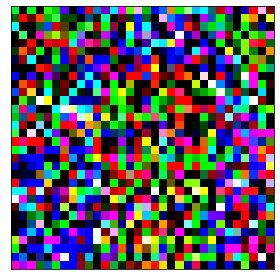

In [30]:
plt.figure(figsize=(4,4))
face_latent = reshape_model_wo_ilogits.inverse(z).cpu().detach()[face_idx].permute(1, 2, 0).numpy()
plt.imshow(face_latent[:, :, :])
plt.xticks([])
plt.yticks([])
plt.tight_layout()
# plt.savefig("img_src/realnvp_celeba/face_z.pdf", bbox_inches='tight')

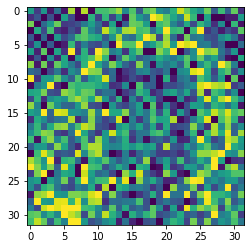

In [31]:
plt.imshow(np.clip(face_latent[:, :, 2], -2, 2))

In [32]:
z_dequantized = []
for _ in range(40):
    z = net(x)
    z_dequantized.append(z.detach().cpu()[face_idx])

zs = torch.stack(z_dequantized, dim=0)
face_latent_avg = reshape_model_wo_ilogits.inverse(zs).mean(dim=0).permute(1, 2, 0).numpy()

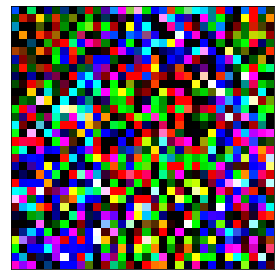

In [34]:
plt.figure(figsize=(4, 4))
plt.imshow(np.clip(face_latent_avg[:, :, ], -2, 2))
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig("img_src/realnvp_celeba/face_z_avg.pdf", bbox_inches='tight')

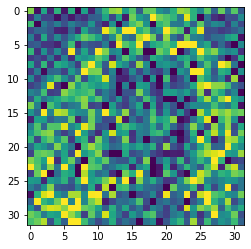

In [35]:
plt.imshow(np.clip(face_latent_avg[:, :, 2], -2, 2))

In [36]:
svhn_idx = 21

In [37]:
for x, _ in svhn_testloader:
    break

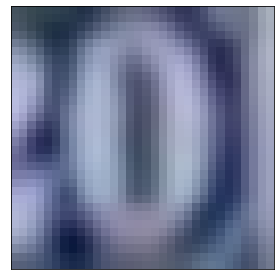

In [38]:
plt.figure(figsize=(4, 4))
nine = x[svhn_idx].cpu().permute(1, 2, 0).numpy()
plt.imshow(nine)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
# plt.savefig("img_src/realnvp_celeba/svhn_9.pdf", bbox_inches='tight')

In [39]:
z = net(x)

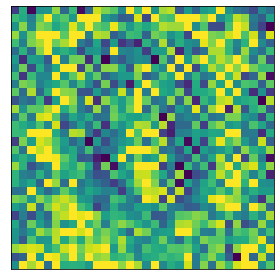

In [41]:
plt.figure(figsize=(4, 4))
nine_latent = reshape_model_wo_ilogits.inverse(z).cpu().detach()[svhn_idx].permute(1, 2, 0).numpy()
plt.imshow(np.clip(nine_latent[:, :, 2], -2, 2))
plt.xticks([])
plt.yticks([])
plt.tight_layout()
# plt.savefig("img_src/realnvp_celeba/svhn_9_z.pdf", bbox_inches='tight')

In [42]:
z_dequantized = []
for _ in range(40):
    z = net(x)
    z_dequantized.append(z.detach().cpu()[svhn_idx])

zs = torch.stack(z_dequantized, dim=0)
nine_latent_avg = reshape_model_wo_ilogits.inverse(zs).mean(dim=0).permute(1, 2, 0).numpy()

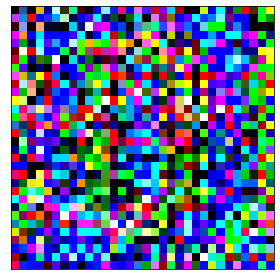

In [43]:
plt.figure(figsize=(4, 4))
plt.imshow(np.clip(nine_latent_avg[:, :, :], -2, 2))
plt.xticks([])
plt.yticks([])
plt.tight_layout()
# plt.savefig("img_src/realnvp_celeba/svhn_9_z_avg.pdf", bbox_inches='tight')

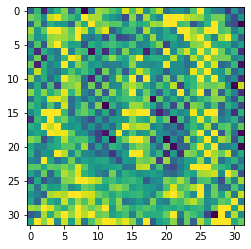

In [45]:
plt.imshow(np.clip(nine_latent_avg[:, :, 2], -2, 2))

In [46]:
face.shape, face_latent.shape, nine.shape, nine_latent.shape

((32, 32, 3), (32, 32, 3), (32, 32, 3), (32, 32, 3))

In [47]:
# np.savez('img_src/realnvp_celeba/latent_space_celeba_svhn.npz',
#          celeba=face, celeba_latent=face_latent,
#          svhn=nine, svhn_latent=nine_latent)

### Train mode

In [48]:
net.train();

In [49]:
for x, _ in testloader:
    break

In [50]:
face_idx = 21

([], <a list of 0 Text yticklabel objects>)

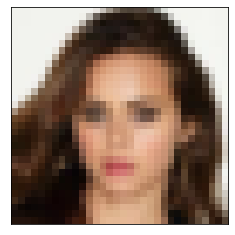

In [51]:
plt.figure(figsize=(4, 4))
plt.imshow(x[face_idx].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])

In [52]:
z = net(x)

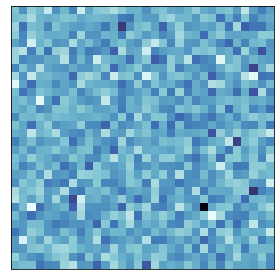

In [53]:
plt.figure(figsize=(4, 4))
face_latent_bn = reshape_model_wo_ilogits.inverse(z)[face_idx].permute(1, 2, 0).cpu().detach().numpy()

# plt.imshow(np.clip(face_latent_bn, -1,1))
# plt.imshow((face_latent_bn[:, :, :] - face_latent_bn[:, :, :].mean()) / face_latent_bn[:, :, :].std())
plt.imshow(face_latent_bn[:, :, 2], cmap=cmo.ice)
# plt.imshow((face_latent_bn[:, :, 2] - face_latent_bn[:, :, 2].mean()) / face_latent_bn[:, :, 2].std())

plt.xticks([])
plt.yticks([])
plt.tight_layout()
# plt.savefig("img_src/realnvp_celeba/face_z_trainmode_channel2.pdf", bbox_inches='tight')

In [55]:
svhn_idx = 21

In [56]:
for x, _ in svhn_testloader:
    break

([], <a list of 0 Text yticklabel objects>)

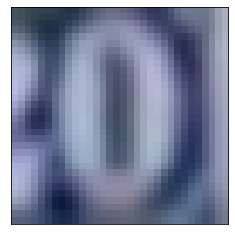

In [57]:
plt.figure(figsize=(4,4))
plt.imshow(x[svhn_idx].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])

In [58]:
z = net(x)

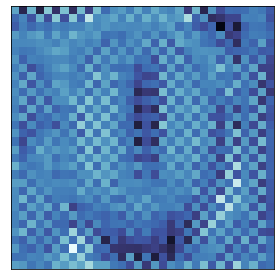

In [59]:
plt.figure(figsize=(4, 4))
nine_latent_bn = reshape_model_wo_ilogits.inverse(z)[svhn_idx].permute(1, 2, 0).cpu().detach().numpy()

# plt.imshow(five_latent_bn)
# plt.imshow((five_latent_bn[:, :, :] - five_latent_bn[:, :, :].mean()) / five_latent_bn[:, :, :].std())
plt.imshow(nine_latent_bn[:, :, 2], cmap=cmo.ice)
# plt.imshow((five_latent_bn[:, :, 2] - five_latent_bn[:, :, 2].mean()) / five_latent_bn[:, :, 2].std())

plt.xticks([])
plt.yticks([])
plt.tight_layout()
# plt.savefig("img_src/realnvp_celeba/svhn_9_z_trainmode_channel2.pdf", bbox_inches='tight')

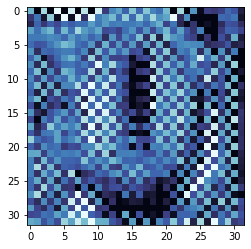

In [63]:
plt.imshow(np.clip(nine_latent_bn[:, :, 2], -5, 5), cmap=cmo.ice)

In [64]:
# np.savez('img_src/realnvp_celeba/latent_space_celeba_svhn_batchnorm.npz',
#          celeba_latent_trainmode=face_latent_bn,
#          svhn_latent_trainmode=nine_latent_bn)

# Latent spaces: bigger appendix figure

In [66]:
reshape_model_ilogits, reshape_model_wo_ilogits = get_reshape_model(
    in_channels=3, num_blocks=8, trainloader=trainloader, num_scales=3)

In [67]:
net.eval();
flowlosslist_fn = FlowLossList(prior)

[-8467.896484375, -7557.0908203125, -7517.666015625, -6120.3076171875, -9344.2451171875, -7515.4892578125, -6646.138671875, -7590.5673828125, -9117.0009765625]


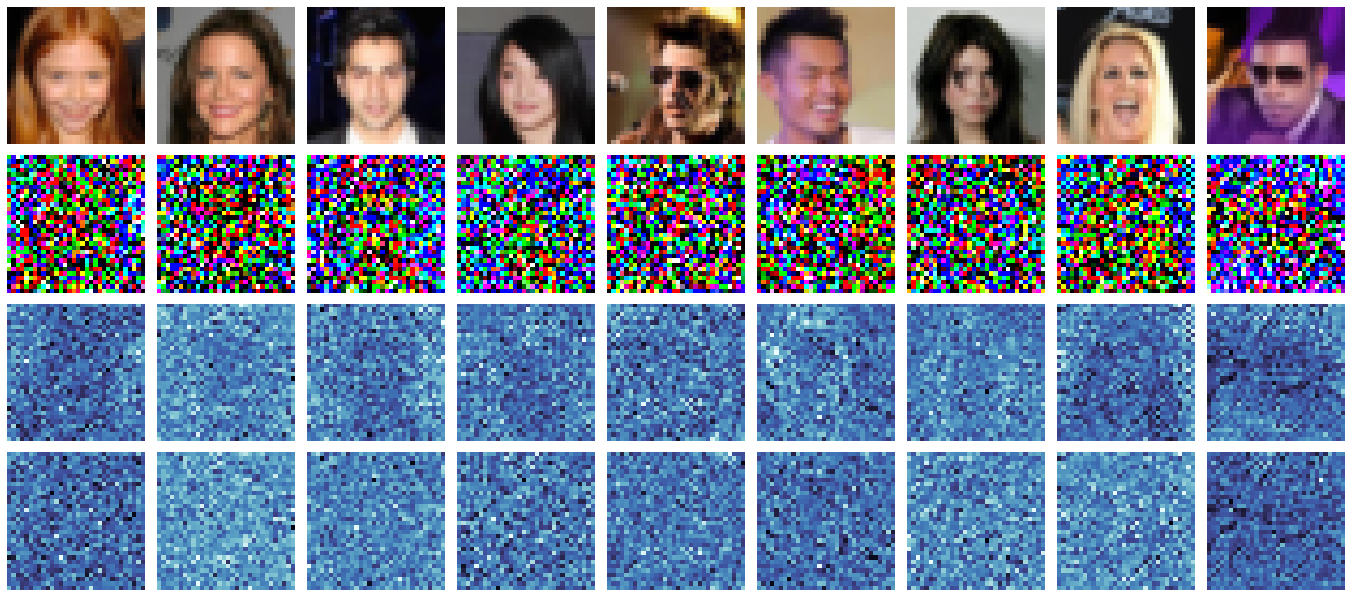

In [81]:
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

img_idx = [2, 3, 6, 8, 10, 11, 13, 16, 24]


# Test mode

net.eval()
for x, _ in testloader:
    break

with torch.no_grad():
    z = net(x)
    sldj = net.module.logdet()
    lls = flowlosslist_fn(z, sldj)

z_reshaped = reshape_model_wo_ilogits.inverse(z).permute(0, 2, 3, 1).detach().cpu().numpy()


# Train mode
net.train()
with torch.no_grad():
    z = net(x)

z_reshaped_trainmode = reshape_model_wo_ilogits.inverse(z).permute(0, 2, 3, 1).detach().cpu().numpy()

x_ = x.permute(0, 2, 3, 1).detach().cpu().numpy()


nrows, ncols = 4, len(img_idx)
fig, arr = plt.subplots(nrows, ncols, figsize=(ncols*2.1, nrows*2.1))
    
for i, idx in enumerate(img_idx):
    arr[0, i].imshow(x_[idx])
    arr[1, i].imshow(z_reshaped[idx])
    arr[2, i].imshow(z_reshaped[idx][:, :, 2], cmap=cmo.ice)
    arr[3, i].imshow(z_reshaped_trainmode[idx][:, :, 2], cmap=cmo.ice)
    arr[0, i].axis('off')
    arr[1, i].axis('off')
    arr[2, i].axis('off')
    arr[3, i].axis('off')

print([lls[idx].item() for idx in img_idx])
plt.tight_layout()

# plt.savefig("img_src/realnvp_celeba/celeba_appendix_latent_space.pdf", bbox_inches='tight')

In [82]:
# np.savez('img_src/realnvp_celeba/celeba_appendix_latent_space.npz',
#          x=x_[img_idx], z=z_reshaped[img_idx], z_trainmode=z_reshaped_trainmode[img_idx])

[-5865.4990234375, -4343.736328125, -5576.685546875, -4759.896484375, -7005.693359375, -5872.0986328125, -6197.0537109375, -6612.962890625, -4935.142578125]


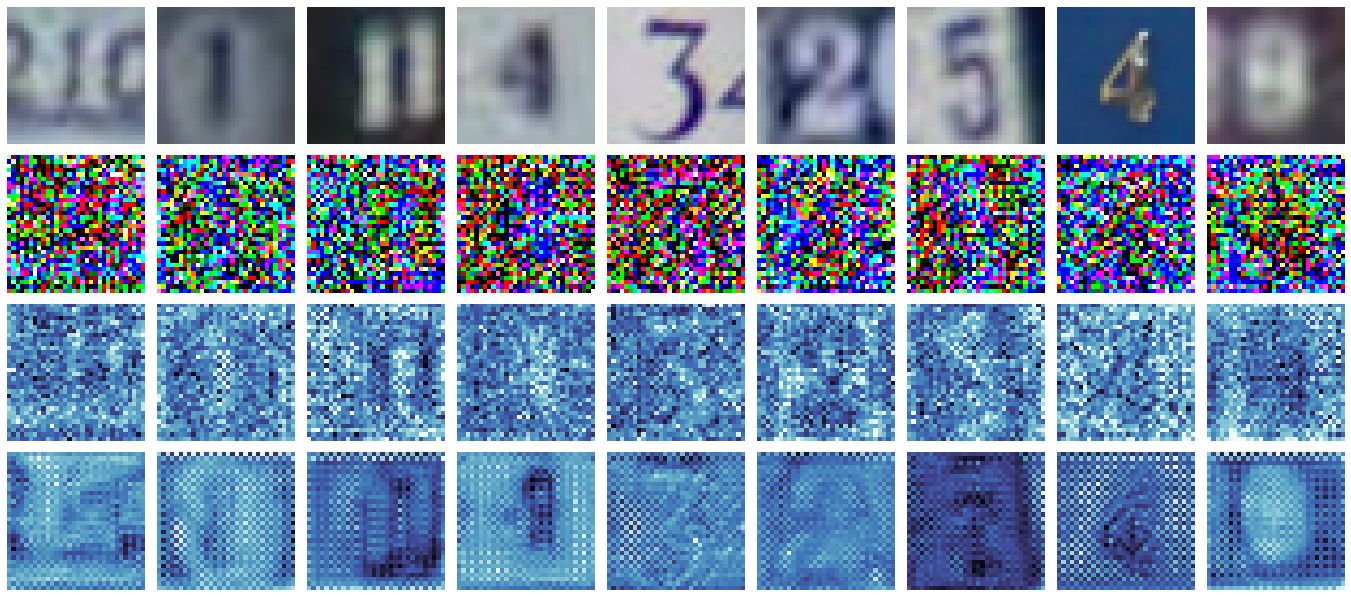

In [102]:
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

img_idx = [2, 5, 7, 15, 18, 20, 25, 26, 30]

# Test mode

net.eval()
for x, _ in svhn_testloader:
    break

with torch.no_grad():
    z = net(x)
    sldj = net.module.logdet()
    lls = flowlosslist_fn(z, sldj)

z_reshaped = reshape_model_wo_ilogits.inverse(z).permute(0, 2, 3, 1).detach().cpu().numpy()


# Train mode
net.train()
with torch.no_grad():
    z = net(x)

z_reshaped_trainmode = reshape_model_wo_ilogits.inverse(z).permute(0, 2, 3, 1).detach().cpu().numpy()

x_ = x.permute(0, 2, 3, 1).detach().cpu().numpy()


nrows, ncols = 4, len(img_idx)
fig, arr = plt.subplots(nrows, ncols, figsize=(ncols*2.1, nrows*2.1))
    
for i, idx in enumerate(img_idx):
    arr[0, i].imshow(x_[idx])
    arr[1, i].imshow(z_reshaped[idx])
    arr[2, i].imshow(np.clip(z_reshaped[idx][:, :, 2], -3, 3), cmap=cmo.ice)
    arr[3, i].imshow(z_reshaped_trainmode[idx][:, :, 2], cmap=cmo.ice)
    arr[0, i].axis('off')
    arr[1, i].axis('off')
    arr[2, i].axis('off')
    arr[3, i].axis('off')

print([lls[idx].item() for idx in img_idx])
plt.tight_layout()
plt.savefig("img_src/realnvp_celeba/svhn_appendix_latent_space.pdf", bbox_inches='tight')

In [103]:
# np.savez('img_src/realnvp_celeba/svhn_appendix_latent_space.npz',
#          x=x_[img_idx], z=z_reshaped[img_idx], z_trainmode=z_reshaped_trainmode[img_idx])